# Introduction

A data scientist currently residing in Downtown Singapore. He currently live within walking distance to Downtown "Telok Ayer MRT metro station" therefore He has access to good public transportation to work. Likewise, He enjoy many ammenities in the neighborhood , such as international cuisine restaurants, cafes', food shops and entertainment. He has been offered a great opportunity to work in Manhattan, NY. Although, He is very excited about it, He is a bit stress toward the process to secure a comparable place to live in Manhattan. Therefore, He decided to apply the learned skills during the Coursera course to explore ways to make sure his decision is factual and rewarding.

The challenge to resolve is being able to find a rental apartment unit in Manhattan NY that offers similar characteristics and benefits to my current situation. Therefore, in order to set a basis for comparison, we want to find a renta unit subject to the following conditions:

- Apartment with min 2 bedrooms with monthly rent not to exceed US$7000/month
- Unit located within walking distance (<=1.0 mile, 1.6 km) from a subway metro station in Manhattan
- Area with ammenities and venues similar to the ones described for the location

## Interested Audience

I believe this is a relevant project for a person or entity considering moving to a major city in Europe, US or Asia, since the approach and methodologies used here are applicable in all cases. The use of FourSquare data and mapping techniques combined with data analysis will help resolve the key questions arisen. Lastly, this project is a good practical case toward the development of Data Science skills.

# Data Section

In order to make a good choice of a similar apartment in Manhattan NY, the following data is required: List/Information on neighborhoods form Manhattan with their Geodata ( latitude and longitude. List/Information about the subway metro stations in Manhattan with geodata. Listed apartments for rent in Manhattan area with descriptions ( how many beds, price, location, address) Venues and ammenities in the Manhattan neighborhoods (e.g. top 10)

## Sources

The list of Manhattan neighborhoods is worked out during LAb exercise during the course. A csv file was created which will be read in order to create a dataframe and its mapping. The csv file 'mh_neigh_data.csv' has the following below data structure. The file will be directly read to the Jupiter Notebook for convenience and space savings. The clustering of neighborhoods and mapping will be shown however. An algorithm was used to determine the geodata from Nominatim .

A list of Manhattan subway metro stops was complied in Numbers (Apple excel) and it was complemeted with wikipedia data ( https://en.wikipedia.org/wiki/List_of_New_York_City_Subway_stations_in_Manhattan) and information from NY Transit authority and Google maps (https://www.google.com/maps/search/manhattan+subway+metro+stations/@40.7837297,-74.1033043,11z/data=!3m1!4b1) for a final consolidated list of subway stops names and their address. The geolocation was obtained via an algorythm using Nominatim. Details will be shown in the execution of methodolody in section 3.0.

A list of places for rent was collected by web-browsing real estate companies in Manhattan : http://www.rentmanhattan.com/index.cfm?page=search&state=results https://www.nestpick.com/search?city=new-york&page=1&order=relevance&district=manhattan&gclid=CjwKCAiAjNjgBRAgEiwAGLlf2hkP3A-cPxjZYkURqQEswQK2jKQEpv_MvKcrIhRWRzNkc_r-fGi0lxoCA7cQAvD_BwE&type=apartment&display=list https://www.realtor.com/apartments/Manhattan_NY A csv file was compiled with the rental place that indicated: areas of Manhattan, address, number of beds, area and monthly rental price. The csv file "nnnn.csv" had the following below structure. An algorythm was used to create all the geodata using Nominatim, as shown in section 3.0. The actual algorythm coding may be shown in 'markdown' mode becasues it takes time to run. With the use of geolocator = Nominatim() , it was possible to determine the latitude and longiude for the subway metro locations as well as for the geodata for each rental place listed. The loop algorythms used are shown in the execution of data in section 3.0 "Great_circle" function from geolocator was used to calculate distances between two points , as in the case to calculate average rent price for units around each subway station and at 1.6 km radius. Foursquare is used to find the avenues at Manhattan neighborhoods in general and a cluster is created to later be able to search for the venues depending of the location shown.

### How the data will be used to solve the problem

The data will be used as follows: Use Foursquare and geopy data to map top 10 venues for all Manhattan neighborhoods and clustered in groups ( as per Course LAB) Use foursquare and geopy data to map the location of subway metro stations , separately and on top of the above clustered map in order to be able to identify the venues and ammenities near each metro station, or explore each subway location separately Use Foursquare and geopy data to map the location of rental places, in some form, linked to the subway locations. create a map that depicts, for instance, the average rental price per square ft, around a radious of 1.0 mile (1.6 km) around each subway station - or a similar metrics. I will be able to quickly point to the popups to know the relative price per subway area. Addresses from rental locations will be converted to geodata( lat, long) using Geopy-distance and Nominatim. Data will be searched in open data sources if available, from real estate sites if open to reading, libraries or other government agencies such as Metro New York MTA, etc.

### Mapping of Data

The following maps were created to facilitate the analysis and the choice of the palace to live. Manhattan map of Neighborhoods manhattan subway metro locations Manhattan map of places for rent Manhattan map of clustered venues and neighborhoods Combined maps of Manhattan rent places with subway locations Combined maps of Manhattan rent places with subway locations and venues clusters

# Implementation

## Upload Libraries Required

In [2]:
!conda install -c conda-forge geopy --yes
print('geopy installed')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0



geopy-1.22.0         | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: 

In [3]:
import numpy as np # library to handle data in a vectorized manner
import time
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import folium 
from folium import plugins

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans

## Mapping Data

#### Singapore Map - Current residence and venues in neighborhood

In [4]:
# Shenton Way, District 01, Singapore
address = 'Mccallum Street, Singapore'
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Singapore home are {}, {}.'.format(latitude, longitude))

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.22.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The geograpical coordinate of Singapore home are 1.2784801, 103.8493717.


In [5]:
neighborhood_latitude=1.2784801
neighborhood_longitude=103.8493717

#### Venues around current residence in Singapore

In [6]:
CLIENT_ID = 'A0J0GDHGCDD1YJNKW5H15WRHYLDYQM2KXG25Z5E2KLSSYLTE' # your Foursquare ID
CLIENT_SECRET = '33KHVJ1UNG3XLU0CHA31L2KPP0ITUTYJD1HEN4MY121E5GXM' # your Foursquare Secret
VERSION = '20200529' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: A0J0GDHGCDD1YJNKW5H15WRHYLDYQM2KXG25Z5E2KLSSYLTE
CLIENT_SECRET:33KHVJ1UNG3XLU0CHA31L2KPP0ITUTYJD1HEN4MY121E5GXM


In [7]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=A0J0GDHGCDD1YJNKW5H15WRHYLDYQM2KXG25Z5E2KLSSYLTE&client_secret=33KHVJ1UNG3XLU0CHA31L2KPP0ITUTYJD1HEN4MY121E5GXM&v=20200529&ll=1.2784801,103.8493717&radius=500&limit=100'

In [8]:
# results display is hidden for report simplification 
results = requests.get(url).json()
#results

In [9]:
# function that extracts the category of the venue - borrow from the Foursquare lab.
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [10]:
venues = results['response']['groups'][0]['items']
SGnearby_venues = json_normalize(venues) # flatten JSON
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
SGnearby_venues =SGnearby_venues.loc[:, filtered_columns]
# filter the category for each row
SGnearby_venues['venue.categories'] = SGnearby_venues.apply(get_category_type, axis=1)
# clean columns
SGnearby_venues.columns = [col.split(".")[-1] for col in SGnearby_venues.columns]

SGnearby_venues.shape

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


(76, 4)

In [11]:
# Venues near current Singapore residence place
SGnearby_venues.head(10)

,name,categories,lat,lng
0,The Westin Singapore,Hotel,1.278275,103.850772
1,Pure Fitness,Gym,1.278631,103.851487
2,Lau Pa Sat Satay Street,Street Food Gathering,1.280261,103.850235
3,Anglo Indian Cafe & Bar,Indian Restaurant,1.279084,103.850127
4,Westin Infinity Pool,Pool,1.278057,103.851077
5,Napoleon Food & Wine Bar,Wine Bar,1.279925,103.847333
6,Sofitel So Singapore,Hotel,1.280017,103.849813
7,Lobby Lounge Westin,Bar,1.277811,103.850966
8,Mellower Coffee,Café,1.277814,103.848188
9,Cook & Brew,Gastropub,1.277842,103.851103


#### Map of Singapore residence place with venues in Neighborhood

In [12]:
latitude=1.2792655
longitude=103.8480938
# create map of Singapore place  using latitude and longitude values
map_sg = folium.Map(location=[latitude, longitude], zoom_start=18)
# add markers to map
for lat, lng, label in zip(SGnearby_venues['lat'], SGnearby_venues['lng'], SGnearby_venues['name']):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=30,
        radius=7,
        popup=label,
        color='blue',
        fill_color='#0f0f0f',
        fill_opacity=0.6,
    ).add_to(map_sg)  
    
map_sg

#### MANHATTAN NEIGHBORHOODS

Note: Cluster neighborhood data was produced with Foursquare during course lab work. A csv file was produced containing the neighborhoods around the 40 Boroughs. Now, the csv file is just read for convenience and consolidation of report.

In [45]:
manhattan_merged = pd.read_csv('manhattan_merged.csv')
manhattan_merged.head()

,Unnamed: 0,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Manhattan,Marble Hill,40.876551,-73.910660,1,Sandwich Place,Gym,Coffee Shop,Yoga Studio,Pharmacy,Supplement Shop,Steakhouse,Shopping Mall,Seafood Restaurant,Pizza Place
1,1,Manhattan,Chinatown,40.715618,-73.994279,0,Chinese Restaurant,Bubble Tea Shop,Cocktail Bar,Bakery,Optical Shop,American Restaurant,Coffee Shop,Ice Cream Shop,Salon / Barbershop,Spa
2,2,Manhattan,Washington Heights,40.851903,-73.936900,1,Café,Bakery,Chinese Restaurant,Mobile Phone Shop,Pizza Place,Grocery Store,Latin American Restaurant,New American Restaurant,Mexican Restaurant,Park
3,3,Manhattan,Inwood,40.867684,-73.921210,1,Mexican Restaurant,Pizza Place,Café,Restaurant,Lounge,Bakery,Chinese Restaurant,Deli / Bodega,Wine Bar,Park
4,4,Manhattan,Hamilton Heights,40.823604,-73.949688,1,Pizza Place,Coffee Shop,Café,Deli / Bodega,Mexican Restaurant,Cocktail Bar,Indian Restaurant,Sushi Restaurant,Yoga Studio,Chinese Restaurant


#### Map of Manhattan neighborhoods with top 10 clustered venues

Note: click for popus and popus allow to identify each neighborhood and the cluster of venues around it in order to proceed to examine in more detail in the next cell

In [46]:
# create map of Manhattan using latitude and longitude values from Nominatim
latitude= 40.7308619
longitude= -73.9871558 

kclusters=5
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
  # add markers for rental places to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters)    
    
       
map_clusters

#### Examine a particular Cluster

In [47]:
## kk is the cluster number to explore
kk = 2
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == kk, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Manhattan,2,Italian Restaurant,Bakery,Gym / Fitness Center,Spa,Coffee Shop,Exhibit,Hotel,Juice Bar,Yoga Studio,Wine Shop
10,Manhattan,2,Coffee Shop,Italian Restaurant,Pizza Place,Cocktail Bar,Café,Sushi Restaurant,Gym / Fitness Center,Gym,Burger Joint,Thai Restaurant
13,Manhattan,2,Italian Restaurant,Plaza,Café,Concert Hall,Theater,Performing Arts Venue,American Restaurant,Wine Shop,French Restaurant,Gym / Fitness Center
14,Manhattan,2,Theater,Gym / Fitness Center,Coffee Shop,Hotel,Gym,Italian Restaurant,Sandwich Place,Cocktail Bar,Pizza Place,Spa
15,Manhattan,2,Coffee Shop,Bakery,Hotel,Theater,Japanese Restaurant,Clothing Store,Cuban Restaurant,Pizza Place,Sandwich Place,Gym
17,Manhattan,2,Art Gallery,Coffee Shop,Café,American Restaurant,Ice Cream Shop,Bakery,Market,Seafood Restaurant,Park,Cupcake Shop
18,Manhattan,2,Italian Restaurant,Café,Gym,Sushi Restaurant,Pizza Place,Coffee Shop,Indian Restaurant,Bakery,Vietnamese Restaurant,Comedy Club
21,Manhattan,2,Italian Restaurant,Park,American Restaurant,Bakery,Café,Spa,Wine Bar,Steakhouse,Skate Park,Scenic Lookout
23,Manhattan,2,Italian Restaurant,Mediterranean Restaurant,Sandwich Place,Gym,Coffee Shop,Clothing Store,Pizza Place,Sushi Restaurant,Ice Cream Shop,Hotel
24,Manhattan,2,Wine Bar,Italian Restaurant,American Restaurant,Park,Bakery,Jazz Club,Pizza Place,New American Restaurant,Cocktail Bar,Coffee Shop


#### Map of Manhattan places for rent

Several Manhattan real estate webs were webscrapped to collect rental data, as mentioned in section 2.0 . The resut was summarized in a csv file for direct reading, in order to consolidate the proces.

The initial data for 144 apartment did not have the latitude and longitude data (NaN) but the information was established in the following cell using an algorythm and Nominatim.

In [51]:
mh_rent=pd.read_csv('MH_rent_latlong.txt')
mh_rent.head()

,Address,Area,Price_per_ft2,Rooms,Area-ft2,Rent_Price,Lat,Long
0,West 105th Street,Upper West Side,2.94,5.0,3400,10000,40.799771,-73.966213
1,East 97th Street,Upper East Side,3.57,3.0,2100,7500,40.788585,-73.955277
2,West 105th Street,Upper West Side,1.89,4.0,2800,5300,40.799771,-73.966213
3,CARMINE ST.,West Village,3.03,2.0,1650,5000,40.730523,-74.001873
4,171 W 23RD ST.,Chelsea,3.45,2.0,1450,5000,40.744118,-73.995299


Manhattan apartment rent price statistics

In [52]:
import matplotlib.pyplot as plt
import itertools
import seaborn as sb
import random
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline


sb.set_style('whitegrid', {'legend.frameon': True})
colors_ = ['yellowgreen', 'lightskyblue','lightcoral', 'gold', 'gray']
random.seed(134)
palette = sb.color_palette(colors_)
sb.set_palette(palette)
sb.set(font_scale=1.2)

No handles with labels found to put in legend.


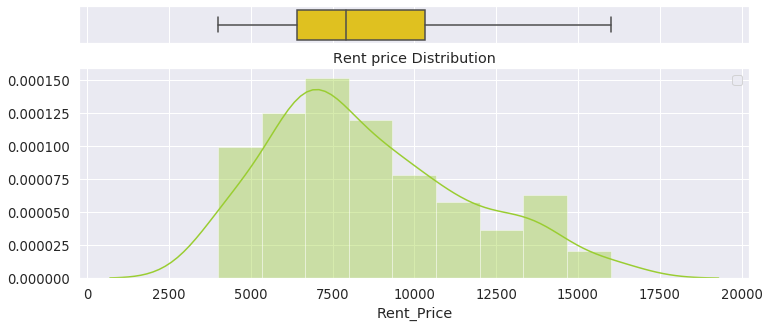

In [53]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)},figsize=(12,5))
sb.boxplot(mh_rent['Rent_Price'], ax=ax_box,color = colors_[3])
sb.distplot(mh_rent['Rent_Price'], color = colors_[0],ax=ax_hist)
plt.title("Rent price Distribution")
plt.legend()
ax_box.set(xlabel='')
plt.show()
# plt.savefig('EDA_graphs\gender.png',bbox_inches='tight')

A US 7000 Dollar per month rent is actually around the mean value

No handles with labels found to put in legend.


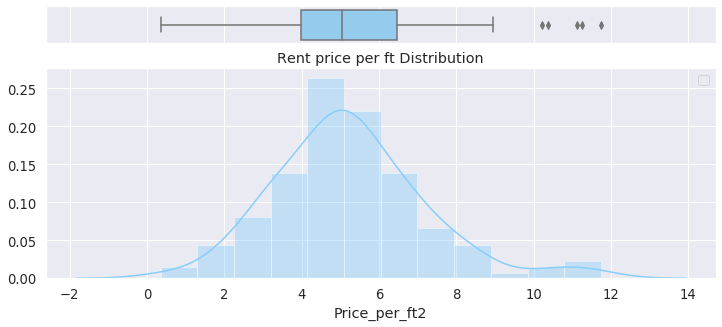

In [54]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)},figsize=(12,5))
sb.boxplot(mh_rent['Price_per_ft2'], ax=ax_box,color = colors_[1])
sb.distplot(mh_rent['Price_per_ft2'], color = colors_[1],ax=ax_hist)
plt.title("Rent price per ft Distribution")
plt.legend()
ax_box.set(xlabel='')
plt.show()
# plt.savefig('EDA_graphs\gender.png',bbox_inches='tight')

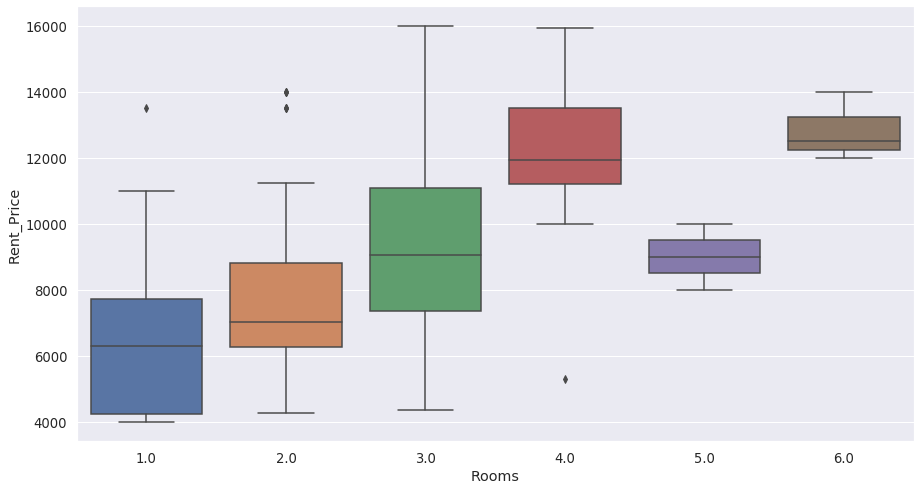

In [55]:
fig, ax = plt.subplots(figsize=(15,8))
sb.boxplot(x='Rooms', y= 'Rent_Price', data=mh_rent)
plt.show()

#### Map of Manhattan apartments for rent

Note: The popups will indicate the address and the monthly price for rent thus making it convenient to select the target appartment with the price condition estipulated (max US7000 )

In [56]:
latitude= 40.7308619
longitude= -73.9871558

map_manhattan_rent = folium.Map(location=[latitude, longitude], zoom_start=12.5)

# add markers to map
for lat, lng, label in zip(mh_rent['Lat'], mh_rent['Long'],'$ ' + mh_rent['Rent_Price'].astype(str)+ ',  '+ mh_rent['Address']):      
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan_rent) 
    

map_manhattan_rent

#### Map of Manhattan showing the places for rent and the cluster of venues

Now, one can point to a rental place for price and address location information while knowing the cluster venues around it.

In [57]:
# create map of Manhattan using latitude and longitude values from Nominatim
latitude= 40.7308619
longitude= -73.9871558

# create map with clusters
kclusters=5
map_clusters2 = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters2)
    
# add markers to map for rental places
for lat, lng, label in zip(mh_rent['Lat'], mh_rent['Long'],'$ ' + mh_rent['Rent_Price'].astype(str)+ mh_rent['Address']):      
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters2)  
    
    # Adds tool to the top right
from folium.plugins import MeasureControl
map_manhattan_rent.add_child(MeasureControl())

# FMeasurement ruler icon to establish distnces on map
from folium.plugins import FloatImage
url = ('https://media.licdn.com/mpr/mpr/shrinknp_100_100/AAEAAQAAAAAAAAlgAAAAJGE3OTA4YTdlLTkzZjUtNDFjYy1iZThlLWQ5OTNkYzlhNzM4OQ.jpg')
FloatImage(url, bottom=5, left=85).add_to(map_manhattan_rent)

map_clusters2

### Now one can explore a particular rental place and its venues in detail

In the map above, examination of apartments with rental place below 7000/month is straightforward while knowing the venues around it.

We could find an apartment with at the right price and in a location with desirable venues. The next step is to see if it is located near a subway metro station, in next cells work.

In [60]:
## kk is the cluster number to explore
kk = 2
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == kk, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Manhattan,2,Italian Restaurant,Bakery,Gym / Fitness Center,Spa,Coffee Shop,Exhibit,Hotel,Juice Bar,Yoga Studio,Wine Shop
10,Manhattan,2,Coffee Shop,Italian Restaurant,Pizza Place,Cocktail Bar,Café,Sushi Restaurant,Gym / Fitness Center,Gym,Burger Joint,Thai Restaurant
13,Manhattan,2,Italian Restaurant,Plaza,Café,Concert Hall,Theater,Performing Arts Venue,American Restaurant,Wine Shop,French Restaurant,Gym / Fitness Center
14,Manhattan,2,Theater,Gym / Fitness Center,Coffee Shop,Hotel,Gym,Italian Restaurant,Sandwich Place,Cocktail Bar,Pizza Place,Spa
15,Manhattan,2,Coffee Shop,Bakery,Hotel,Theater,Japanese Restaurant,Clothing Store,Cuban Restaurant,Pizza Place,Sandwich Place,Gym
17,Manhattan,2,Art Gallery,Coffee Shop,Café,American Restaurant,Ice Cream Shop,Bakery,Market,Seafood Restaurant,Park,Cupcake Shop
18,Manhattan,2,Italian Restaurant,Café,Gym,Sushi Restaurant,Pizza Place,Coffee Shop,Indian Restaurant,Bakery,Vietnamese Restaurant,Comedy Club
21,Manhattan,2,Italian Restaurant,Park,American Restaurant,Bakery,Café,Spa,Wine Bar,Steakhouse,Skate Park,Scenic Lookout
23,Manhattan,2,Italian Restaurant,Mediterranean Restaurant,Sandwich Place,Gym,Coffee Shop,Clothing Store,Pizza Place,Sushi Restaurant,Ice Cream Shop,Hotel
24,Manhattan,2,Wine Bar,Italian Restaurant,American Restaurant,Park,Bakery,Jazz Club,Pizza Place,New American Restaurant,Cocktail Bar,Coffee Shop


#### Mapping Manhattan Subway locations

Manhattan subway metro locations ( address) was obtained from webscrapping sites such as Wikipedia, Google and NY Metro Transit. For simplification, a csv file was produced from the 'numbers' (Apple excel ) so that the reading of this file is the starting point here.

The geodata will be obtain via Nominatim using the algorythm below.

In [61]:
# A csv file summarized the subway station and the addresses for next step to determine geodata
mh=pd.read_csv('NYC_subway_list.txt')
mh.head()

,sub_station,sub_address
0,Dyckman Street Subway Station,"170 Nagle Ave, New York, NY 10034, USA"
1,57 Street Subway Station,"New York, NY 10106, USA"
2,Broad St,"New York, NY 10005, USA"
3,175 Street Station,"807 W 177th St, New York, NY 10033, USA"
4,5 Av and 53 St,"New York, NY 10022, USA"


#### Add colums labeled 'lat' and 'long' to be filled with geodata

In [62]:
#  Add columns 'lat'  and 'long' to mh dataframe - with random temporary numbers to get started
sLength = len(mh['sub_station'])
lat = pd.Series(np.random.randn(sLength))
long=pd.Series(np.random.randn(sLength))
mh = mh.assign(lat=lat.values)
mh = mh.assign(long=long.values)

In [67]:
## Read csv file that produced the subway stations list with geodata
mh=pd.read_csv('MH_subway.txt')
print(mh.shape)
mh.head()

(76, 4)


,sub_station,sub_address,lat,long
0,Dyckman Street Subway Station,"170 Nagle Ave, New York, NY 10034, USA",40.861857,-73.924509
1,57 Street Subway Station,"New York, NY 10106, USA",40.764250,-73.954525
2,Broad St,"New York, NY 10005, USA",40.730862,-73.987156
3,175 Street Station,"807 W 177th St, New York, NY 10033, USA",40.847991,-73.939785
4,5 Av and 53 St,"New York, NY 10022, USA",40.764250,-73.954525


In [68]:
# removing duplicate rows and creating new set mhsub1
mhsub1=mh.drop_duplicates(subset=['lat','long'], keep="last").reset_index(drop=True)
mhsub1.shape

(22, 4)

#### MAP of Manhattan showing the location of subway stations

In [69]:
# map subway stations 
# create map of Manhattan using latitude and longitude values obtain previoulsy via Moninatim geolocator
latitude=40.7308619
longitude=-73.9871558

map_mhsub1 = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers of subway locations to map
for lat, lng, label in zip(mhsub1['lat'], mhsub1['long'],  mhsub1['sub_station'].astype(str) ):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=6,
        radius=6,
        popup=label,
        color='red',
        fill_color='red',
        fill_opacity=2.5,
    ).add_to(map_mhsub1) 
map_mhsub1

### Map of Manhattan showing places for rent and the subway locations nearby

Now, we can visualize the desirable rental places and their nearest subway station. Pop-ups display rental address and monthly rental price and the subway station name.

Notice that the icon in the top-right corner is a "ruler" that allows to measure the distance from a rental place to an specific subway station

In [70]:
mh_rent.head()

,Address,Area,Price_per_ft2,Rooms,Area-ft2,Rent_Price,Lat,Long
0,West 105th Street,Upper West Side,2.94,5.0,3400,10000,40.799771,-73.966213
1,East 97th Street,Upper East Side,3.57,3.0,2100,7500,40.788585,-73.955277
2,West 105th Street,Upper West Side,1.89,4.0,2800,5300,40.799771,-73.966213
3,CARMINE ST.,West Village,3.03,2.0,1650,5000,40.730523,-74.001873
4,171 W 23RD ST.,Chelsea,3.45,2.0,1450,5000,40.744118,-73.995299


In [72]:
# create map of Manhattan using latitude and longitude values from Nominatim
latitude= 40.7308619
longitude= -73.9871558

map_manhattan_rent = folium.Map(location=[latitude, longitude], zoom_start=13.3)

# add markers to map
for lat, lng, label in zip(mh_rent['Lat'], mh_rent['Long'],'$ ' + mh_rent['Rent_Price'].astype(str)+ mh_rent['Address']):      
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan_rent) 
    
    # add markers of subway locations to map
for lat, lng, label in zip(mhsub1['lat'], mhsub1['long'],  mhsub1['sub_station'].astype(str) ):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=6,
        radius=6,
        popup=label,
        color='red',
        fill_color='red',
        fill_opacity=2.5,
    ).add_to(map_manhattan_rent) 
    
    # Adds tool to the top right
from folium.plugins import MeasureControl
map_manhattan_rent.add_child(MeasureControl())

# Measurement ruler icon tool to measure distances in map
from folium.plugins import FloatImage
url = ('https://media.licdn.com/mpr/mpr/shrinknp_100_100/AAEAAQAAAAAAAAlgAAAAJGE3OTA4YTdlLTkzZjUtNDFjYy1iZThlLWQ5OTNkYzlhNzM4OQ.jpg')
FloatImage(url, bottom=5, left=85).add_to(map_manhattan_rent)

map_manhattan_rent

# Results

Let's consolidate all the required information to make the apartment selection in one map

#### Map of Manhattan with rental places, subway locations and cluster of venues

Red dots are Subway stations, Blue dots are apartments available for rent, Bubbles are the clusters of venues

In [73]:
# create map of Manhattan using latitude and longitude values from Nominatim
latitude= 40.7308619
longitude= -73.9871558

map_mh_one = folium.Map(location=[latitude, longitude], zoom_start=13.3)

# add markers to map
for lat, lng, label in zip(mh_rent['Lat'], mh_rent['Long'],'$ ' + mh_rent['Rent_Price'].astype(str)+ ', '+mh_rent['Address']):      
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mh_one) 
    
    # add markers of subway locations to map
for lat, lng, label in zip(mhsub1['lat'], mhsub1['long'],  mhsub1['sub_station'].astype(str) ):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=6,
        radius=6,
        popup=label,
        color='red',
        fill_color='red',
        fill_opacity=2.5,
    ).add_to(map_mh_one) 


# set color scheme for the clusters
kclusters=5
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=15,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_mh_one)

    # Adds tool to the top right
from folium.plugins import MeasureControl
map_mh_one.add_child(MeasureControl())

# Measurement ruler icon tool to measure distances in map
from folium.plugins import FloatImage
url = ('https://media.licdn.com/mpr/mpr/shrinknp_100_100/AAEAAQAAAAAAAAlgAAAAJGE3OTA4YTdlLTkzZjUtNDFjYy1iZThlLWQ5OTNkYzlhNzM4OQ.jpg')
FloatImage(url, bottom=5, left=85).add_to(map_mh_one)

map_mh_one

## Problem Solving - Select the apartment for rent

### The above consolidate map was used to explore options.

#### After examining, I have chosen two locations that meet the requirements which will assess to make a choice.

- Apartment 1: 305 East 63rd Street in the Sutton Place Neighborhood and near 'subway 59th Street' station, Cluster # 2 - -   Monthly rent : 7500 Dollars

- Apartment 2: 19 Dutch Street in the Financial District Neighborhood and near 'Fulton Street Subway' station, Cluster # 3   Monthly rent : 6935 Dollars

### Venues for Apartment 1 - Cluster 1

In [77]:
## kk is the cluster number to explore
kk = 1
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == kk, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,1,Sandwich Place,Gym,Coffee Shop,Yoga Studio,Pharmacy,Supplement Shop,Steakhouse,Shopping Mall,Seafood Restaurant,Pizza Place
2,Manhattan,1,Café,Bakery,Chinese Restaurant,Mobile Phone Shop,Pizza Place,Grocery Store,Latin American Restaurant,New American Restaurant,Mexican Restaurant,Park
3,Manhattan,1,Mexican Restaurant,Pizza Place,Café,Restaurant,Lounge,Bakery,Chinese Restaurant,Deli / Bodega,Wine Bar,Park
4,Manhattan,1,Pizza Place,Coffee Shop,Café,Deli / Bodega,Mexican Restaurant,Cocktail Bar,Indian Restaurant,Sushi Restaurant,Yoga Studio,Chinese Restaurant
5,Manhattan,1,Coffee Shop,Seafood Restaurant,Italian Restaurant,Deli / Bodega,Park,Mexican Restaurant,Check Cashing Service,Climbing Gym,Chinese Restaurant,Café
7,Manhattan,1,Mexican Restaurant,Bakery,Thai Restaurant,Latin American Restaurant,Pizza Place,Deli / Bodega,Sandwich Place,Gym,Grocery Store,Beer Bar
9,Manhattan,1,Coffee Shop,Italian Restaurant,Gym,Bar,Sushi Restaurant,Deli / Bodega,Diner,Japanese Restaurant,Mexican Restaurant,Pizza Place
12,Manhattan,1,Italian Restaurant,Dessert Shop,Wine Bar,Bakery,Bar,Coffee Shop,Seafood Restaurant,Pub,Sushi Restaurant,Pizza Place
16,Manhattan,1,Japanese Restaurant,Sandwich Place,Coffee Shop,Gym / Fitness Center,Pizza Place,Hotel,Grocery Store,Chinese Restaurant,Juice Bar,Mediterranean Restaurant
25,Manhattan,1,Coffee Shop,Pizza Place,Bar,Mexican Restaurant,Yoga Studio,Grocery Store,Playground,Park,Latin American Restaurant,Korean Restaurant


### Venues for Apartment 2 - Cluster 2

In [78]:
## kk is the cluster number to explore
kk = 2
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == kk, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Manhattan,2,Italian Restaurant,Bakery,Gym / Fitness Center,Spa,Coffee Shop,Exhibit,Hotel,Juice Bar,Yoga Studio,Wine Shop
10,Manhattan,2,Coffee Shop,Italian Restaurant,Pizza Place,Cocktail Bar,Café,Sushi Restaurant,Gym / Fitness Center,Gym,Burger Joint,Thai Restaurant
13,Manhattan,2,Italian Restaurant,Plaza,Café,Concert Hall,Theater,Performing Arts Venue,American Restaurant,Wine Shop,French Restaurant,Gym / Fitness Center
14,Manhattan,2,Theater,Gym / Fitness Center,Coffee Shop,Hotel,Gym,Italian Restaurant,Sandwich Place,Cocktail Bar,Pizza Place,Spa
15,Manhattan,2,Coffee Shop,Bakery,Hotel,Theater,Japanese Restaurant,Clothing Store,Cuban Restaurant,Pizza Place,Sandwich Place,Gym
17,Manhattan,2,Art Gallery,Coffee Shop,Café,American Restaurant,Ice Cream Shop,Bakery,Market,Seafood Restaurant,Park,Cupcake Shop
18,Manhattan,2,Italian Restaurant,Café,Gym,Sushi Restaurant,Pizza Place,Coffee Shop,Indian Restaurant,Bakery,Vietnamese Restaurant,Comedy Club
21,Manhattan,2,Italian Restaurant,Park,American Restaurant,Bakery,Café,Spa,Wine Bar,Steakhouse,Skate Park,Scenic Lookout
23,Manhattan,2,Italian Restaurant,Mediterranean Restaurant,Sandwich Place,Gym,Coffee Shop,Clothing Store,Pizza Place,Sushi Restaurant,Ice Cream Shop,Hotel
24,Manhattan,2,Wine Bar,Italian Restaurant,American Restaurant,Park,Bakery,Jazz Club,Pizza Place,New American Restaurant,Cocktail Bar,Coffee Shop


### Apartment Selection

#### Using the "one map" above, I was able to explore all possibilities since the popups provide the information needed for a good decision.

Apartment 1 rent cost is US7500 slightly above the US7000 budget. Apt 1 is located 400 meters from subway station at 59th Street and work place ( Park Ave and 53rd) is another 600 meters way. I can walk to work place and use subway for other places aroung. Venues for this apt are as of Cluster 2 and it is located in a fine district in the East side of Manhattan.

Apartment 2 rent cost is US6935, just under the US7000 budget. Apt 2 is located 60 meters from subway station at Fulton Street, but I will have to ride the subway daily to work , possibly 40-60 min ride. Venues for this apt are as of Cluster 3.

I feel that Cluster 2 type of venues is a closer resemblance to targeted place. That means that APARTMENT 1 is a better choice since the extra monthly rent is worth the conveniences it provides.

## Thank you for Reviewing